In [14]:
from __future__ import print_function
from __future__ import division
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import os, fnmatch, copy, time
import numpy as np
import math
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from PIL import Image
from torch.utils.data import DataLoader

In [15]:
from torchvision import transforms as T
from torch.utils import data

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 2 to use
random.seed(1)

def get_filepath(dir_root):
    file_paths = []
    for root, dirs, files in os.walk(dir_root):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

class DriverDatasetTrain(data.Dataset):
    def __init__(self, data_root, transforms=None, train=True):
        self.train = train
        imgs_in = get_filepath(data_root)
        random.shuffle(imgs_in)
        imgs_num = len(imgs_in)

        if transforms is None:
            self.transforms = T.Compose([
                                         T.Resize(size = (224, 224)),
                                         T.ToTensor(),
                                         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                         ])

        if self.train:
            self.imgs = imgs_in[:int(0.7 * imgs_num)]
        else:
            self.imgs = imgs_in[int(0.7 * imgs_num):]

    def __getitem__(self, index):
        img_path = self.imgs[index]

        label = int(img_path.split('/')[-2][1:])
        data = Image.open(img_path)
        data = self.transforms(data)
        return data, label

    def __len__(self):
        return len(self.imgs)

class DriverDatasetTest(data.Dataset):
    def __init__(self, data_root, transforms=None):

        self.imgs_in = get_filepath(data_root)

        if transforms is None:
            self.transforms = T.Compose([T.Resize(size=(224,224)),
                                         T.ToTensor(),
                                         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                         ])

    def __getitem__(self, index):
        img_path = self.imgs_in[index]

        data = Image.open(img_path)
        data = self.transforms(data)
        return data, img_path

    def __len__(self):
        return len(self.imgs_in)

In [16]:
def train(model, device, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
        
    train_losses.append(loss.item())

In [17]:
def validation(model, device, vali_loader, vali_losses):
    model.eval()
    vali_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in vali_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            vali_loss += F.cross_entropy(output, target, reduction = 'sum').item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    vali_loss/=len(vali_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        vali_loss, correct, len(vali_loader.dataset), 100. * correct / len(vali_loader.dataset)))
    
    vali_losses.append(vali_loss)

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
model_name = ""
num_classes=11
feature_extract=True
use_pretrained=False #False
def initialize_model(model_name, num_classes=11, feature_extract=True, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "resnext101_32x8d":
        """ Resnext101_32x8d
        """
        model_ft = models.resnext101_32x8d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "wide_resnet101_2":
        """ Wide_resnet101_2
        """
        model_ft = models.wide_resnet101_2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "densenet":
        """ Densenet161
        """
        model_ft = models.densenet161()
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "squeezenet":
        """ Squeezenet1_1
        """
        model_ft = models.squeezenet1_1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
        
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size
    
# Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
# print(model_ft)

In [20]:
# Hyperparameters
max_epoch = 100 #max_epoch             200
alpha = 0.001 #learning rate           0.001 0.005 0.01 0.05 0.1
bth_size = 64 #batch size             32 64 128 256 512 1024
gam = 0.95 #gamma(discount factor)    0.1 0.5 0.9

In [21]:
train_data_path = './imgs/train'
test_data_path = './imgs/test2'

train_data = DriverDatasetTrain(train_data_path, train=True)
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=bth_size, num_workers=4)

vali_data = DriverDatasetTrain(train_data_path, train=False)
vali_loader = DataLoader(dataset=vali_data, shuffle=False, batch_size=bth_size, num_workers=4)

test_data = DriverDatasetTest(test_data_path)
test_loader = DataLoader(dataset = test_data, shuffle=False, batch_size=1, num_workers=1)


======== Epoch: 1 ========
Train Epoch: 0 [0/18994 (0%)]	Loss: 2.461384
Train Epoch: 0 [3200/18994 (17%)]	Loss: 2.304458
Train Epoch: 0 [6400/18994 (34%)]	Loss: 2.300038
Train Epoch: 0 [9600/18994 (51%)]	Loss: 2.470852
Train Epoch: 0 [12800/18994 (67%)]	Loss: 2.456915
Train Epoch: 0 [16000/18994 (84%)]	Loss: 2.252779

Validation set: Average loss: 2.5014, Accuracy: 993/8141 (12%)

======== Epoch: 2 ========
Train Epoch: 1 [0/18994 (0%)]	Loss: 2.438398
Train Epoch: 1 [3200/18994 (17%)]	Loss: 2.384140
Train Epoch: 1 [6400/18994 (34%)]	Loss: 2.542851
Train Epoch: 1 [9600/18994 (51%)]	Loss: 2.405273
Train Epoch: 1 [12800/18994 (67%)]	Loss: 2.459203
Train Epoch: 1 [16000/18994 (84%)]	Loss: 2.419386

Validation set: Average loss: 2.3822, Accuracy: 1381/8141 (17%)

======== Epoch: 3 ========
Train Epoch: 2 [0/18994 (0%)]	Loss: 2.274531
Train Epoch: 2 [3200/18994 (17%)]	Loss: 2.221858
Train Epoch: 2 [6400/18994 (34%)]	Loss: 2.400073
Train Epoch: 2 [9600/18994 (51%)]	Loss: 2.427088
Train Epoch:

Train Epoch: 21 [3200/18994 (17%)]	Loss: 2.165427
Train Epoch: 21 [6400/18994 (34%)]	Loss: 2.212390
Train Epoch: 21 [9600/18994 (51%)]	Loss: 2.480136
Train Epoch: 21 [12800/18994 (67%)]	Loss: 2.306027
Train Epoch: 21 [16000/18994 (84%)]	Loss: 2.419487

Validation set: Average loss: 2.2128, Accuracy: 1623/8141 (20%)

======== Epoch: 23 ========
Train Epoch: 22 [0/18994 (0%)]	Loss: 2.405433
Train Epoch: 22 [3200/18994 (17%)]	Loss: 2.319799
Train Epoch: 22 [6400/18994 (34%)]	Loss: 2.190206
Train Epoch: 22 [9600/18994 (51%)]	Loss: 2.317789
Train Epoch: 22 [12800/18994 (67%)]	Loss: 2.145741
Train Epoch: 22 [16000/18994 (84%)]	Loss: 2.276275

Validation set: Average loss: 2.1742, Accuracy: 1922/8141 (24%)

======== Epoch: 24 ========
Train Epoch: 23 [0/18994 (0%)]	Loss: 2.099128
Train Epoch: 23 [3200/18994 (17%)]	Loss: 2.334372
Train Epoch: 23 [6400/18994 (34%)]	Loss: 2.058218
Train Epoch: 23 [9600/18994 (51%)]	Loss: 2.165841
Train Epoch: 23 [12800/18994 (67%)]	Loss: 2.069549
Train Epoch: 23

Train Epoch: 42 [3200/18994 (17%)]	Loss: 2.078654
Train Epoch: 42 [6400/18994 (34%)]	Loss: 2.342476
Train Epoch: 42 [9600/18994 (51%)]	Loss: 2.212625
Train Epoch: 42 [12800/18994 (67%)]	Loss: 2.295604
Train Epoch: 42 [16000/18994 (84%)]	Loss: 2.128177

Validation set: Average loss: 2.2269, Accuracy: 1801/8141 (22%)

======== Epoch: 44 ========
Train Epoch: 43 [0/18994 (0%)]	Loss: 2.135004
Train Epoch: 43 [3200/18994 (17%)]	Loss: 2.019002
Train Epoch: 43 [6400/18994 (34%)]	Loss: 2.168707
Train Epoch: 43 [9600/18994 (51%)]	Loss: 2.281085
Train Epoch: 43 [12800/18994 (67%)]	Loss: 2.120471
Train Epoch: 43 [16000/18994 (84%)]	Loss: 2.153122

Validation set: Average loss: 2.1333, Accuracy: 2144/8141 (26%)

======== Epoch: 45 ========
Train Epoch: 44 [0/18994 (0%)]	Loss: 2.106053
Train Epoch: 44 [3200/18994 (17%)]	Loss: 1.974815
Train Epoch: 44 [6400/18994 (34%)]	Loss: 2.280438
Train Epoch: 44 [9600/18994 (51%)]	Loss: 1.917452
Train Epoch: 44 [12800/18994 (67%)]	Loss: 2.408720
Train Epoch: 44

Train Epoch: 63 [3200/18994 (17%)]	Loss: 2.264900
Train Epoch: 63 [6400/18994 (34%)]	Loss: 2.104790
Train Epoch: 63 [9600/18994 (51%)]	Loss: 2.133943
Train Epoch: 63 [12800/18994 (67%)]	Loss: 2.173011
Train Epoch: 63 [16000/18994 (84%)]	Loss: 2.040811

Validation set: Average loss: 2.0632, Accuracy: 2207/8141 (27%)

======== Epoch: 65 ========
Train Epoch: 64 [0/18994 (0%)]	Loss: 2.150059
Train Epoch: 64 [3200/18994 (17%)]	Loss: 2.269385
Train Epoch: 64 [6400/18994 (34%)]	Loss: 2.055418
Train Epoch: 64 [9600/18994 (51%)]	Loss: 2.268933
Train Epoch: 64 [12800/18994 (67%)]	Loss: 2.036131
Train Epoch: 64 [16000/18994 (84%)]	Loss: 2.095022

Validation set: Average loss: 2.0797, Accuracy: 2251/8141 (28%)

======== Epoch: 66 ========
Train Epoch: 65 [0/18994 (0%)]	Loss: 2.067456
Train Epoch: 65 [3200/18994 (17%)]	Loss: 2.042976
Train Epoch: 65 [6400/18994 (34%)]	Loss: 2.291420
Train Epoch: 65 [9600/18994 (51%)]	Loss: 2.220240
Train Epoch: 65 [12800/18994 (67%)]	Loss: 2.089171
Train Epoch: 65

Train Epoch: 84 [3200/18994 (17%)]	Loss: 2.025331
Train Epoch: 84 [6400/18994 (34%)]	Loss: 1.754357
Train Epoch: 84 [9600/18994 (51%)]	Loss: 2.226048
Train Epoch: 84 [12800/18994 (67%)]	Loss: 1.967890
Train Epoch: 84 [16000/18994 (84%)]	Loss: 2.008042

Validation set: Average loss: 2.0624, Accuracy: 2424/8141 (30%)

======== Epoch: 86 ========
Train Epoch: 85 [0/18994 (0%)]	Loss: 1.921778
Train Epoch: 85 [3200/18994 (17%)]	Loss: 1.990088
Train Epoch: 85 [6400/18994 (34%)]	Loss: 2.265441
Train Epoch: 85 [9600/18994 (51%)]	Loss: 2.142740
Train Epoch: 85 [12800/18994 (67%)]	Loss: 2.082561
Train Epoch: 85 [16000/18994 (84%)]	Loss: 2.041027

Validation set: Average loss: 2.0441, Accuracy: 2224/8141 (27%)

======== Epoch: 87 ========
Train Epoch: 86 [0/18994 (0%)]	Loss: 2.171978
Train Epoch: 86 [3200/18994 (17%)]	Loss: 2.113296
Train Epoch: 86 [6400/18994 (34%)]	Loss: 2.127267
Train Epoch: 86 [9600/18994 (51%)]	Loss: 1.969834
Train Epoch: 86 [12800/18994 (67%)]	Loss: 2.070183
Train Epoch: 86

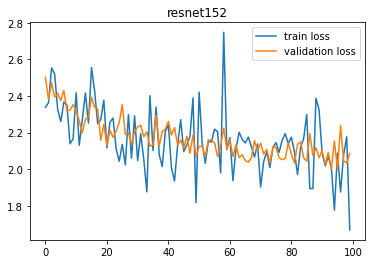

In [21]:
model_list = ["resnet50", "resnet152", "resnext101_32x8d", "wide_resnet101_2", "densenet", "squeezenet"]
model_name = model_list[4] #[4]
model_ft, input_size = initialize_model(model_name, num_classes=11)    # input_size = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model_ft.to(device)
optimizer = optim.Adam(model.parameters(), lr = alpha)
scheduler = StepLR(optimizer, step_size = 1, gamma = gam)

train_losses = []
validation_losses = []
for epoch in range(max_epoch):
    print("======== Epoch: {} ========".format(epoch + 1))
    train(model, device, train_loader, optimizer, epoch, train_losses)
    validation(model, device, vali_loader, validation_losses)
    
plt.plot(train_losses, label='train loss')
plt.plot(validation_losses, label='validation loss')
plt.legend()
plt.title(model_name)
plt.show()
#print('Best accuracy of '+model_name+' during training: {:.4f}'.format(test_best_acc))

torch.save(model.state_dict(), "trained.model")

In [22]:
def predict(model, device, test_loader):
    model.eval()
    result = []
    for (data, path) in test_loader:
        path = path[0].split('/')
        with torch.no_grad():
            data = data.to(device)
            y = model(data)
            output = nn.Softmax(dim = 1)(y)[0].cpu().numpy()
            temp = []
            temp.append(path[-1])
            for j in range(11):
                temp.append(output[j])
            result.append(temp)
    
    df_ = pd.DataFrame(result, columns = ['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10'])
    df_.to_csv("result.csv", index=False)

In [10]:
# model, input_size = initialize_model("densenet", num_classes=10)
# model = model_ft.to(device)
# model.load_state_dict(torch.load("trained.model"))
predict(model, device, test_loader)

NameError: name 'model' is not defined

In [23]:
!pwd

# Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
# print(model_ft)
device = 'cuda'
model_ft, input_size = initialize_model("densenet", num_classes=11)

model_ft.load_state_dict(torch.load("./trained_densenet.model"))
model = model_ft.to(device)
predict(model, device, test_loader)

/home/smkim/Driver_Detection
